In [1]:
#Import des biblothèques utiles

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import scipy.linalg as la
from time import process_time
from Parameters import *
from Hydrogen import *
from Field import *

## Présentation de la méthode des éléments finis pour TDSE


We will apply the Crank-Nicolson (CN) scheme to integrate numerically Eq. 1 in one space dimension with Neumann boundary conditions.

$$i \frac{\partial \psi}{\partial t} = -\frac{1}{2} \frac{\partial^2 \psi}{\partial x^2} + V(x) \psi - x E(t) \psi, \qquad (Eq. 1)$$



# Finite Difference Methods

The above Schrödinger equation describes the time evolution of the variable $\psi(x,t)$ in one space dimension.

To approximate $\psi(x,t)$ numerically, we discretize the coordinate system with a two-dimensional regular grid.

Let us discretize both time and space:
$$t_n = n \Delta t, \quad n = 0, \dots, N - 1,$$
$$x_j = j \Delta x, \quad j = 0, \dots, J - 1,$$

where $N$ and $J$ are the number of discrete time and space points, respectively, and $Δt$ and $Δx$ are the time and space steps:
$$Δt = T / N, \quad Δx = L / J,$$

where $T$ is the final integration time.

Our goal is to approximate the unknown analytic solution $\psi(x,t)$ at discrete grid points, using the notation:
$$\Psi^n_j = \psi(jΔx, nΔt) \approx \psi(jΔx, nΔt).$$

# The Crank-Nicolson Stencil

To approximate the time derivative at grid point $(j,n)$, we use:
$$ \left. \frac{\partial \psi}{\partial t} \right|_{x = jΔx, t = nΔt} \approx \frac{\Psi^{n+1}_j - \Psi^n_j}{Δt}.$$

The spatial part of the Crank-Nicolson stencil for the Schrödinger equation ($i \psi_t = -\frac{1}{2} \psi_{xx} + V(x) \psi - x E(t) \psi$) approximates the Laplacian and potential operators as follows:
$$-\frac{1}{2} \left. \frac{\partial^2 \psi}{\partial x^2} \right|_{x = jΔx, t = nΔt} \approx \frac{-1}{4Δx^2} \left( \Psi^n_{j+1} - 2 \Psi^n_j + \Psi^n_{j-1} + \Psi^{n+1}_{j+1} - 2 \Psi^{n+1}_j + \Psi^{n+1}_{j-1} \right),$$


Applying this stencil to the grid point $(j,n)$ gives:
$$i\frac{\Psi^{n+1}_j - \Psi^n_j}{Δt} = \frac{-1}{4Δx^2} (\Psi^n_{j+1} - 2 \Psi^n_j + \Psi^n_{j-1} + \Psi^{n+1}_{j+1} - 2 \Psi^{n+1}_j + \Psi^{n+1}_{j-1}) + {V(x_j)} \Psi^n_j  - {x_j E(t_n)} \Psi^n_j.$$


and letting f in the second member we obtain : 

$$i\frac{\Psi^{n+1}_j - \Psi^n_j}{Δt} = \frac{-1}{4Δx^2} (\Psi^n_{j+1} - 2 \Psi^n_j + \Psi^n_{j-1} + \Psi^{n+1}_{j+1} - 2 \Psi^{n+1}_j + \Psi^{n+1}_{j-1}) + {f(\Psi^n_j)}.$$



# Reordering Stencil into Linear System

Let us define $\sigma \equiv \frac{DΔt}{2Δx^2}$  and reorder the above approximation of our reaction-diffusion equation:
$$−(\sigma)U^{n+1}_{j−1}+(1+2\sigma)U^{n+1}_j−(\sigma )U^{n+1}_{j+1}=(\sigma)U^n_{j−1}+(1−2\sigma)U^n_j+(\sigma)U^n_{j+1}+Δt f(U^n_j).$$

This equation makes sense for space indices $j=1,…,J−2$ but it does not make sense for indices $j=0$ and $j=J−1$

(on the boundaries):
$$j=0: −(σ)U^{n+1}_{−1}+(1+2σ)U^{n+1}_{0}−(σ)U^{n+1}_{1}=(σ)U^n_{−1}+(1−2σ)U^n_0+(σ)U^n_1+Δt \, f(U^n_0),$$
$$j=J−1: −(σ)U^{n+1}_{J−2}+(1+2σ)U^{n+1}_{J−1}−(σ)U^{n+1}_J=(σ)U^n_{J−2}+(1−2σ)U^n_{J−1}+(σ)U^n_J+Δt\,f(U^n_{J−1}).$$

The problem here is that the values $U^{n−1}_{-1}$ and $U^n_J$ lie outside our grid.

However, we can work out what these values should equal by considering our Neumann boundary condition. Let us discretize our boundary condition at $j=0$ with the backward difference and at $j=J−1$ with the forward difference:
$$\frac{U^n_1−U^n_{-1}}{2Δx}=0,$$
$$\frac{U^n_J−U^n_{J−2}}{2Δx}=0.$$

These two equations make it clear that we need to amend our above numerical approximation for $j=0$ with the identities $U^n_{-1}=U^n_1$ and $U^{n+1}_{-1}=U^{n+1}_1$, and for $j=J−1$ with the identities $U^n_{J−2}=U^n_J$ and $U^{n+1}_{J−2}=U^{n+1}_J$.

Let us reinterpret our numerical approximation of the line concentration of $u$
in a fixed point in time as a vector $\mathbf{U}^n$:
$$\mathbf{U}^n=\left [  
\begin{array}{c}
U_0^n \\
\vdots \\
U_{J-1}^n
\end{array}\right ].$$

Using this notation we can now write our above approximation for a fixed point in time, $t=n \Delta t$, compactly as a linear system:
$$\left [  
\begin{array}{ccccccc}
1+2\sigma & - 2\sigma & 0 & 0 & \ldots & 0 \\
-(\sigma) & 1+ 2 \sigma & - (\sigma) & 0 & \ldots & 0 \\
 0 & -(\sigma) & 1+ 2 \sigma & - (\sigma) & \ldots & 0 \\
 0 & 0 & \ddots & \ddots  & \ddots & 0 \\
 0 & 0 & 0 &-(\sigma) & 1+ 2 \sigma & - (\sigma) \\
 0 & 0 & 0 & 0 &-2\sigma & 1+ 2 \sigma
\end{array}\right ]
\left [  
\begin{array}{c}
U_0^{n+1} \\
U_1^{n+1} \\
U_2^{n+1} \\
\vdots \\
U_{J-2}^{n+1}\\
U_{J-1}^{n+1}\\
\end{array}\right ]=
$$
$$
\left [  
\begin{array}{ccccccc}
1-2\sigma & + 2\sigma & 0 & 0 & \ldots & 0 \\
\sigma & 1 -2 \sigma & + \sigma & 0 & \ldots & 0 \\
 0 & \sigma & 1- 2 \sigma & + \sigma & \ldots & 0 \\
 0 & 0 & \ddots & \ddots  & \ddots & 0 \\
 0 & 0 & 0 &+\sigma & 1- 2 \sigma & + \sigma \\
 0 & 0 & 0 & 0 &+2\sigma & 1- 2 \sigma
\end{array}\right ]
\left [  
\begin{array}{c}
U_0^{n} \\
U_1^{n} \\
U_2^{n} \\
\vdots \\

U_{J-2}^{n}\\
U_{J-1}^{n}\\
\end{array}\right ]+
\Delta t \left [ \begin{array}{c}
f(U_0^{n}) \\
f(U_1^{n}) \\
f(U_2^{n}) \\
\vdots \\
f(U_{J-2}^{n})\\
f(U_{J-1}^{n})\\
\end{array}\right ]
$$




In [79]:
class CrankNicolson:
    
    def set_grid(self, x_min, x_max, n_x, t_min, t_max, n_t):

        self.x_min, self.x_max, self.n_x = x_min, x_max, n_x
        self.t_min, self.t_max, self.n_t = t_min, t_max, n_t
        self.x_pts, self.delta_x = np.linspace(x_min, x_max, n_x, retstep=True, endpoint=False)
        self.t_pts, self.delta_t = np.linspace(t_min, t_max, n_t, retstep=True, endpoint=False)
        
    def set_parameter(self,f):
        
        self.f = f
    
    def _make_tridiag(self, sig, n, data_type):
        
        M = np.diagflat(np.full(n, (1+2*sig), dtype=data_type)) +\
            np.diagflat(np.full(n-1, (-sig), dtype=data_type), 1) +\
            np.diagflat(np.full(n-1, (-sig), dtype=data_type), -1)
        
        return M
    
    def solve(self, psi_init, sparse=True):
        
        sig = (1j*self.delta_t)/(4*(self.delta_x)**2)
        data_type = type(psi_init[0]*sig)
        
        self.psi_matrix = np.zeros([self.n_t, self.n_x],dtype=data_type)
        
        
        A = self._make_tridiag(sig, self.n_x,data_type)
        B = self._make_tridiag(-sig, self.n_x, data_type)
        
        for i in [0,1]:
            A[1,-i] = 1.0
            A[2*i,1-3*i] = 0.0
            B[-i,-i] = 0.0
            B[-i,1-3*i] = 0.0
            
        psi = psi_init
        for k in range(self.n_t):
            t = self.t_min + k*self.delta_t
            self.psi_matrix[k,:] = psi
            fpsi = self.f(psi,t)
            if k==0: fpsi_old = fpsi
            psi = la.solve(A, B.dot(psi) - 1j* self.delta_t * (1.5 * fpsi - 0.5 * fpsi_old))
            fpsi_old = fpsi
        
        
        
    def get_final_psi(self):
        return self.psi_matrix[-1,:].copy()
        

In [88]:
## Test pour un simple Pulse

#Création du solveur
crank = CrankNicolson()


#Def du champ laser simple

param_single_pulse = pars_YanPengPhysRevA_78_033821()[0]
Field_single_pulse = Field.Pulse(param_single_pulse)
def Field_test(t):
    return Field_single_pulse(t,'Real')

#Def du potentiel 

atom = Hydrogen() 
def Potentiel_test(x):
    return atom.soft_core_potential(x)

# Those will not change
l = ((1/(2*Field_single_pulse.w))**2)*0.5*Field_single_pulse.a
x_min, x_max, nx = -30*l, 30*l, 600
t_min, t_max, nt = -100, 100., 100

#Paramétrisation du solveur
crank.set_grid(x_min, x_max, nx, t_min, t_max, nt)
X = crank.x_pts
def f(u,t):
    return Potentiel_test(X)*u - X*u*Field_test(t)
crank.set_parameter(f)
psi_init = atom.ground_state_wavefunction(X)


In [89]:
t1 = process_time()
crank.solve(psi_init)
t2 = process_time()
print("time to advance %i steps with full (%i x %i) matrices :"%(nt,nx,nx), t2-t1, "s")

time to advance 100 steps with full (600 x 600) matrices : 62.9413399999994 s


/Users/arthurgontier/anaconda3/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


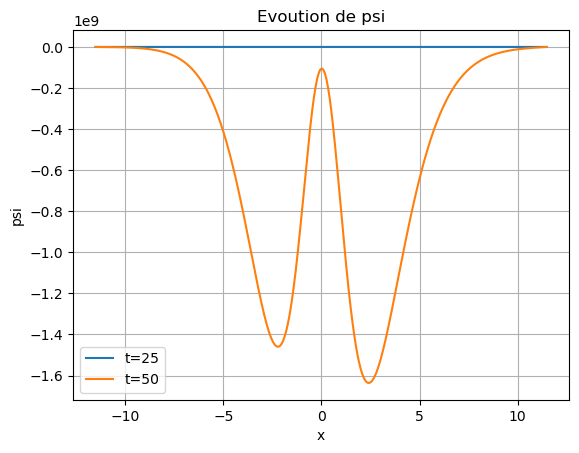

In [90]:
plt.figure()
#plt.plot(X,crank.psi_matrix[0,:], label='t=0')
plt.plot(X,crank.psi_matrix[25,:], label='t=25')
plt.plot(X,crank.psi_matrix[50,:], label='t=50')
plt.xlabel('x')
plt.ylabel('psi')
plt.grid()
plt.legend()
plt.title('Evoution de psi')
plt.show()

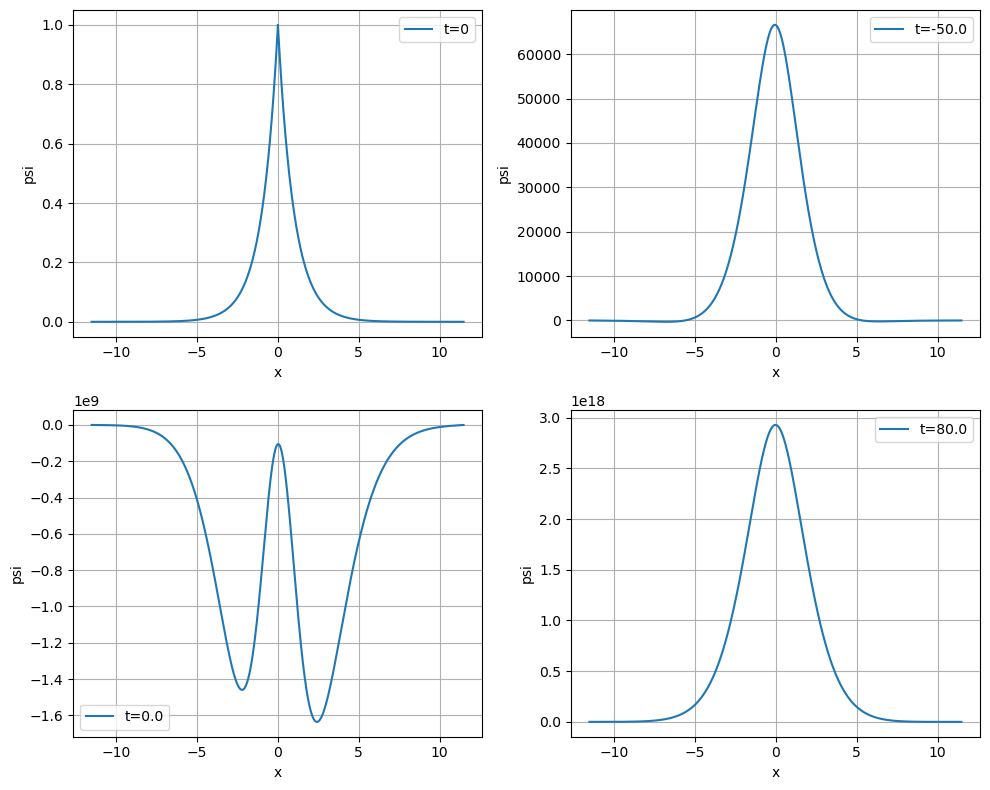

In [91]:
# Créer une figure avec une disposition de 2 lignes et 2 colonnes
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Liste des temps et des indices correspondants
times = [0, 25, 50, 90]
labels = ['t={}'.format(0), 't={}'.format(crank.t_min+25*crank.delta_t), 't={}'.format(crank.t_min+50*crank.delta_t), 't={}'.format(crank.t_min+90*crank.delta_t)]

# Parcourir chaque sous-graphe
for ax, t, label in zip(axs.flat, times, labels):
    ax.plot(X, crank.psi_matrix[t, :], label=label)
    ax.set_xlabel('x')
    ax.set_ylabel('psi')
    ax.grid()
    ax.legend()

# Ajuster la disposition
plt.tight_layout()
plt.show()
